In [1]:
#import demo_util
import numpy as np
import torch

from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert


attention mode is flash


In [6]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
#titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [7]:
config = demo_util.get_config("configs/titok_s128.yaml")

In [8]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_s128.bin', 'generator_checkpoint': 'generator_titok_s128.bin', 'output_dir': 'titok_s_128'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'small', 'vit_dec_model_size': 'small', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 128, 'finetune_decoder': True}, 'generator': {'model_type': 'UViT', 'hidden_size': 1024, 'num_hidden_layers': 20, 'num_attention_heads': 16, 'intermediate_size': 4096, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 64, 'mask_schedule_strategy': 'arccos', 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 2.8, 'guidance_scale': 6.9, 'guidance_decay': 'power-cosine'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [2]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
from modeling.titok import TiTok
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)

print(titok_tokenizer)

TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(1024, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_

In [3]:
# # supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
# titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_s128_imagenet")
# titok_generator.eval()
# titok_generator.requires_grad_(False)

# # or alternatively, downloads from hf
# # hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# # titok_generator = demo_util.get_titok_generator(config)
# print(titok_generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 1024)
      (position_embeddings): Embedding(129, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-19): 20 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affin

In [3]:
device = "cpu"
titok_tokenizer = titok_tokenizer.to(device)
#titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [3]:
# Remember to put in the correct size though! 
# Tokenize an Image into 32 discrete tokens
device = torch.device("cpu")
def tokenize_and_reconstruct(img_path):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

def tokenize_and_quantize(img_path): 
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    quantized_image = titok_tokenizer.codebook_quantize_tokens(encoded_tokens)
    print(quantized_image.shape)
    return quantized_image


Input Image is represented by codes tensor([[[1255, 2603,  982, 2222,  643, 1426,  866, 4094,  296, 1422,  398,
           764, 3670, 1265, 3986,  759, 1039, 3962, 2373, 2337, 1372, 4050,
          4012, 3644, 2624, 3735, 1539, 1289, 2817, 2985, 2550, 2972]]]) with shape torch.Size([1, 1, 32])
orginal image:


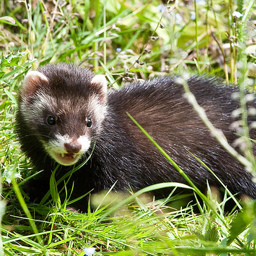

reconstructed image:


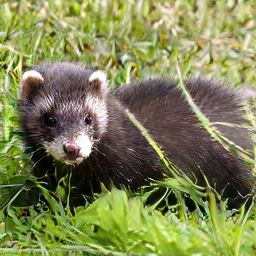

torch.Size([32, 12])
torch.Size([1, 12, 1, 32])


tensor([[[[ 0.4116, -0.3318,  0.2247, -0.3639,  0.1763,  0.3381, -0.1653,
            0.2460, -0.2310,  0.3156, -0.2562, -0.3801,  0.4243, -0.2047,
            0.0372, -0.4003, -0.1867, -0.0022,  0.2198, -0.3448, -0.1604,
           -0.2977,  0.2160, -0.4028,  0.1230, -0.3922, -0.0242,  0.1138,
            0.0145, -0.3426,  0.2444, -0.1566]],

         [[ 0.3137,  0.1079, -0.3281,  0.3469, -0.2075,  0.1527,  0.0203,
            0.1522, -0.1328,  0.1206,  0.5883, -0.2316, -0.2341,  0.4718,
           -0.0361,  0.3670, -0.1331, -0.0070, -0.0210,  0.1688,  0.2742,
           -0.2016, -0.5011,  0.0196,  0.0256,  0.1582,  0.1925,  0.2542,
           -0.4640, -0.0332, -0.2267, -0.1088]],

         [[ 0.0203,  0.2067, -0.2626, -0.1026,  0.0557,  0.2241, -0.0598,
            0.1222,  0.3732,  0.0049,  0.0953, -0.0750, -0.1475, -0.1659,
            0.1454,  0.0045,  0.3908, -0.0466, -0.2972,  0.0948,  0.2736,
            0.1215, -0.0213, -0.0672, -0.0342,  0.2261,  0.1160, -0.1419,
           -

In [4]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")
tokenize_and_quantize("assets/ILSVRC2012_val_00008636.png")

Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326, 2598]]]) with shape torch.Size([1, 1, 32])
orginal image:


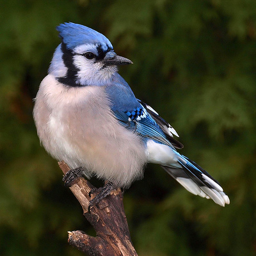

reconstructed image:


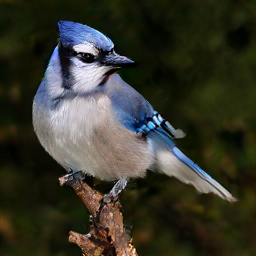

torch.Size([1, 12, 1, 32])


tensor([[[[ 3.0019e-01,  5.9544e-01,  4.8955e-01,  2.9417e-01, -9.8822e-02,
            3.5456e-01, -2.8423e-02, -4.1109e-01,  1.3970e-01, -6.8022e-03,
           -9.0964e-02, -2.4304e-01,  2.9138e-01, -3.0839e-01, -4.3541e-02,
            6.8109e-02,  1.6549e-01,  1.2481e-01,  3.8823e-01,  4.1847e-02,
            2.8417e-01,  2.1462e-01, -2.6123e-01,  5.0354e-01,  4.2340e-01,
            2.9342e-01, -1.5355e-01, -1.2003e-01,  3.4962e-01, -1.7834e-01,
            3.8324e-01,  6.1214e-01]],

         [[ 1.0392e-01, -5.0896e-03,  4.3531e-01,  3.7996e-02, -3.7918e-01,
           -1.1140e-01, -8.2158e-02,  3.9373e-01,  2.9510e-01,  1.4826e-01,
            4.7945e-01,  8.4362e-02,  4.2710e-01,  2.4673e-01,  4.9585e-02,
           -2.3122e-01,  2.2314e-01,  5.8606e-01, -1.4270e-02,  4.4979e-01,
           -3.2353e-01, -3.5778e-02, -5.3779e-01, -2.6615e-01, -3.6743e-01,
           -3.9732e-01, -3.4252e-01,  4.3998e-01,  5.0398e-02, -2.1669e-01,
           -2.4708e-01, -2.3835e-01]],

        

In [9]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")
tokenize_and_quantize("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

In [ ]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))

NameError: name 'titok_generator' is not defined